# Neural Networks Learning

In this part, we will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

# 1. Neural Networks

In the previous part, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights. In this part, we will implement the backpropagation algorithm to learn the parameters for the neural network.

In [462]:
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mat
from __future__ import division
from scipy import optimize as op

In [2]:
data1 = mat.loadmat("E:\\Machine Learning\\1\\ex4data1.mat")

In [15]:
X_matrix = np.mat(data1["X"])
Y_matrix = np.mat(data1["y"])

Visualizing the data

In [19]:
random_indices = np.random.permutation(np.shape(X_matrix)[0])

X_matrix_plot = X_matrix[random_indices[0:100], :]
Y_matrix_plot = Y_matrix[random_indices[0:100], :]

In [29]:
rows = np.shape(X_matrix_plot)[0]
cols = np.shape(X_matrix_plot)[1]

example_width = int(cols ** 0.5)
example_height = cols / example_width

display_rows = int(np.floor(rows ** 0.5))
display_cols = int(np.ceil(rows / display_rows))

In [47]:
pad = 1

display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))

curr_ex = 0
for j in range(0, display_rows, 1):
    for i in range(0, display_cols, 1):
        max_val = np.max(abs(X_matrix_plot[curr_ex, :]))
        display_array[pad + j * (example_height + pad): pad + j * (example_height + pad) + example_height, \
            pad + i * (example_width + pad): pad + i * (example_width + pad) + example_width] = \
            np.reshape(X_matrix_plot[curr_ex, :], (example_height, example_width)) / max_val
        
        curr_ex = curr_ex + 1

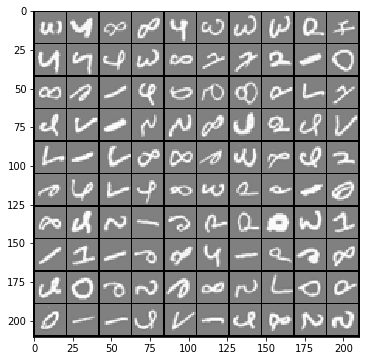

In [48]:
plt.figure(num = 1, figsize = (6, 6))

plt.imshow(display_array, cmap = "gray")

Model Representation

The neural network has 3 layers --- an input layer, a hidden layer, and an output layer.

In [49]:
data2 = mat.loadmat("E:\\Machine Learning\\1\\ex4weights.mat")

In [69]:
theta1_matrix = np.transpose(np.mat(data2["Theta1"]))
theta2_matrix = np.transpose(np.mat(data2["Theta2"]))

Feedforward and cost function

Cost function:

J1 = sum(-Y_k * log(H_x_k) - (1 - Y_k) * log(1 - H_x_k))

J_theta = 1/m * sum(J1)

In [154]:
def costFunction(theta1, theta2):
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    m = np.shape(X_matrix)[0]
    num_labels = np.shape(theta2)[1]
    X_matrix_all = np.hstack((one, X_matrix))
    
    H_x_layer2 = 1 / (1 + np.exp(-X_matrix_all * theta1_matrix))
    input_layer2 = np.hstack((one, H_x_layer2))
    
    H_x_layer3 = 1 / (1 + np.exp(-input_layer2 * theta2_matrix))
    
    
    Y_array_coded = np.zeros(m * 10).reshape(m, num_labels)
    
    for i in range(0, m, 1):
        Y_array_coded[i][Y_matrix[i] - 1] = 1
        
    Y_matrix_all = np.mat(Y_array_coded)
    
    J_theta = sum(-np.multiply(Y_matrix_all, np.log(H_x_layer3)) - np.multiply(1 - Y_matrix_all, np.log(1 - H_x_layer3)))
    J_theta_all = sum(np.transpose(J_theta))[0, 0] / m
    
    
    return J_theta_all

In [155]:
costFunction(theta1_matrix, theta2_matrix)

0.2876291651613187

Regularized cost function

Cost function:

J1 = sum(-Y_k * log(H_x_k) - (1 - Y_k) * log(1 - H_x_k))

J_theta = 1/m * sum(J1) + lambda/(2m) * (sum(theta1^2) + sum(theta2^2)),   not including "bias unit"

In [195]:
def costFunctionReg(theta1, theta2, lambda1):
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    m = np.shape(X_matrix)[0]
    num_labels = np.shape(theta2)[1]
    X_matrix_all = np.hstack((one, X_matrix))
    
    H_x_layer2 = 1 / (1 + np.exp(-X_matrix_all * theta1_matrix))
    input_layer2 = np.hstack((one, H_x_layer2))
    
    H_x_layer3 = 1 / (1 + np.exp(-input_layer2 * theta2_matrix))
    
    
    Y_array_coded = np.zeros(m * 10).reshape(m, num_labels)
    
    for i in range(0, m, 1):
        Y_array_coded[i][Y_matrix[i] - 1] = 1
        
    Y_matrix_all = np.mat(Y_array_coded)
    
    J_theta = sum(-np.multiply(Y_matrix_all, np.log(H_x_layer3)) - np.multiply(1 - Y_matrix_all, np.log(1 - H_x_layer3)))
    J_theta_part1 = sum(np.transpose(J_theta))[0, 0] / m
    
    
    theta1_matrix_new = theta1_matrix[1:, :]
    theta2_matrix_new = theta2_matrix[1:, :]
    
    theta1_matrix_new_part1 = sum(np.power(theta1_matrix_new, 2)) 
    theta1_matrix_new_all = sum(np.transpose(theta1_matrix_new_part1))
    
    theta2_matrix_new_part1 = sum(np.power(theta2_matrix_new, 2))
    theta2_matrix_new_all = sum(np.transpose(theta2_matrix_new_part1))
    
    J_theta = J_theta_part1 + lambda1/(2*m) * (theta1_matrix_new_all + theta2_matrix_new_all)[0, 0]
    
    
    return J_theta

In [196]:
costFunctionReg(theta1_matrix, theta2_matrix, 1)

0.3837698590909235

# 2. Backpropagation

In this part, we will implement the backpropagation algorithm to compute the gradient for the neural network cost function.

Sigmoid Gradient:

g'(z) = g(z)(1 - g(z))

where

sigmoid(z) = g(z) = 1 / (1 + exp(-z))

In [289]:
def sigmoid(z):
    G_z = 1 / (1 + np.exp(-z))
    
    return np.multiply(G_z, 1 - G_z)

Random Initialization

When training neural networks, it is important to randomly initialize the parameters. One effective strategy for random initialization is to randomly select values for Theta(layer l) uniformly in the range (-a, a). We should use a = 0.12. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [208]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [224]:
def randWeights(size_in, size_out):
    epsilon = 0.12
    
    np.random.seed(111)
    weights = np.random.rand(size_in + 1, size_out) * 2 * epsilon - epsilon
    
    
    return weights

In [226]:
np.shape(randWeights(input_layer_size, hidden_layer_size))

(401, 25)

Backpropagation

Steps:

1) Perform a feedforward pass

a1(2) = g(theta_10(1) * x0 + theta_11(1) * x1 + theta_12(1) * x2 + theta_13(1) * x3) = g(z1(2))

a2(2) = g(theta_20(1) * x0 + theta_21(1) * x1 + theta_22(1) * x2 + theta_23(1) * x3) = g(z2(2))

a3(2) = g(theta_30(1) * x0 + theta_31(1) * x1 + theta_32(1) * x2 + theta_33(1) * x3) = g(z3(2))

H_x = g(theta_10(2) * a0(2) + theta_11(2) * a1(2) + theta_12(2) * a2(2) + theta_13(2) * a3(2))

In [262]:
def forwardProp(theta1, theta2):
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    X_matrix_withOne = np.hstack((one, X_matrix))
    z_layer1 = X_matrix_withOne * theta1_matrix
    
    H_x_layer2 = 1 / (1 + np.exp(-z_layer1))
    input_layer2 = np.hstack((one, H_x_layer2))
    z_layer2 = input_layer2 * theta2_matrix
    
    H_x_layer3 = 1 / (1 + np.exp(-z_layer2))
    
    
    return H_x_layer3

In [266]:
forwardProp(theta1_matrix, theta2_matrix)

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

2) For each output unit k in layer 3, set 

epsilon_k(3) = a_k(3) - y_k

In [273]:
def error3(theta1, theta2, a3):
    m = np.shape(X_matrix)[0]
    num_labels = np.shape(theta2)[1]
    
    Y_array_coded = np.zeros(m * 10).reshape(m, num_labels)
    
    for i in range(0, m, 1):
        Y_array_coded[i][Y_matrix[i] - 1] = 1
        
    
    epsilon_layer3 = a3 - Y_array_coded
        
        
    return epsilon_layer3

In [274]:
H_x_layer3 = forwardProp(theta1_matrix, theta2_matrix)

error3(theta1_matrix, theta2_matrix, H_x_layer3)

matrix([[ 1.12661530e-04,  1.74127856e-03,  2.52696959e-03, ...,
          4.01468105e-04,  6.48072305e-03, -4.26598801e-03],
        [ 4.79026796e-04,  2.41495958e-03,  3.44755685e-03, ...,
          2.39107046e-03,  1.97025086e-03, -4.30306860e-03],
        [ 8.85702310e-05,  3.24266731e-03,  2.55419797e-02, ...,
          6.22892325e-02,  5.49803551e-03, -7.19916032e-02],
        ...,
        [ 5.17641791e-02,  3.81715020e-03,  2.96297510e-02, ...,
          2.15667361e-03, -3.50173050e-01,  2.42384687e-05],
        [ 8.30631310e-04,  6.22003774e-04,  3.14518512e-04, ...,
          1.19366192e-02, -2.85895014e-02,  2.06173648e-04],
        [ 4.81465717e-05,  4.58821829e-04,  2.15146201e-05, ...,
          5.73434571e-03, -3.03711010e-01,  8.18576980e-02]])

3) For the hidden layer l = 2, set

epsilon(2) = transpose(theta2) * epsilon(3) .* g'(z(2))

In [325]:
epsilon_layer3 = error3(theta1_matrix, theta2_matrix, H_x_layer3)

def error2(theta1, theta2):
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    X_matrix_withOne = np.mat(np.hstack((one, X_matrix)))
    z_2 = X_matrix_withOne * theta1_matrix
    G_z2 = sigmoid(z_2)
    
    theta2_matrix_noOne = theta2_matrix[1:, :]
    epsilon_layer2 = np.multiply(epsilon_layer3 * np.transpose(theta2_matrix_noOne), G_z2)
    
    
    return epsilon_layer2

In [326]:
error2(theta1_matrix, theta2_matrix)

matrix([[-2.56039197e-04,  1.64609258e-03, -4.66882057e-05, ...,
         -5.78480912e-04, -1.15655603e-03,  2.07368588e-03],
        [ 9.74599807e-06, -7.00181468e-05, -1.36863959e-03, ...,
         -1.29358710e-03,  1.05698694e-05,  1.79696295e-03],
        [ 1.48402367e-04, -1.33889678e-03, -2.45497283e-04, ...,
         -6.73260875e-03, -2.38305860e-03, -4.28811805e-03],
        ...,
        [-6.92053786e-02, -7.53307697e-02,  2.41162810e-02, ...,
         -1.13222007e-02,  1.71139585e-02,  8.85670526e-02],
        [ 2.32727194e-03, -1.10398917e-02, -1.68258871e-05, ...,
         -1.23887269e-04, -1.60723254e-02, -1.84235400e-03],
        [-6.39446351e-03, -3.12774931e-06,  1.97368384e-03, ...,
          3.34843369e-05,  5.43344849e-02,  2.77275644e-02]])

4) Accumulate the gradient:

delta(l) = delta(l) + epsilon(l+1) * a(l)

delta(2) = delta(2) + epsilon(3) * H_x_layer2

delta(1) = delta(1) + epsilon(2) * X_matrix

In [345]:
epsilon_layer3 = error3(theta1_matrix, theta2_matrix, H_x_layer3)
epsilon_layer2 = error2(theta1_matrix, theta2_matrix)

one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
X_matrix_withOne = np.hstack((one, X_matrix))
H_x_layer2 = X_matrix_withOne * theta1_matrix
input_layer2 = np.hstack((one, H_x_layer2))

delta_layer2 = np.transpose(input_layer2) * epsilon_layer3


input_layer1 = X_matrix_withOne
delta_layer1 = np.transpose(input_layer1) * epsilon_layer2


5) Obtain the (unregularized) gradient:

G_theta(2) = 1/m * delta(2)

G_theta(1) = 1/m * delta(1)

In [351]:
m = np.shape(X_matrix)[0]

G_theta_layer2 = 1/m * delta_layer2
G_theta_layer1 = 1/m * delta_layer1


Combined function:

In [441]:
def gradientCombined(theta1, theta2):
    
    # Feedforward propagation
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    input_layer1 = np.hstack((one, X_matrix))
    H_x_layer2 = 1 / (1 + np.exp(-input_layer1 * theta1_matrix))
    
    input_layer2 = np.hstack((one, H_x_layer2))
    H_x_layer3 = 1 / (1 + np.exp(-input_layer2 * theta2_matrix))
    
    
    # Errors in Layer3
    Y_matrix_coded = np.mat(np.zeros((len(Y_matrix), num_labels)))
    for i in range(0, len(Y_matrix), 1):
        Y_matrix_coded[i, Y_matrix[i, 0] - 1] = 1
    
    errors_layer3 = H_x_layer3 - Y_matrix_coded
    
    
    # Errors in Layer2
    z_layer2 = input_layer1 * theta1_matrix
    G_z2 = sigmoid(z_layer2)
    theta2_matrix_noOne = theta2_matrix[1:, :]
    errors_layer2 = np.multiply(errors_layer3 * np.transpose(theta2_matrix_noOne), G_z2)
    
    
    # Delta
    delta_layer2 = np.transpose(input_layer2) * errors_layer3
    delta_layer1 = np.transpose(input_layer1) * errors_layer2
    
    
    # Unregularized gradient
    G_layer2 = delta_layer2 / m
    G_layer1 = delta_layer1 / m
    
    
    return G_layer2, G_layer1

In [443]:
gradientCombined(theta1_matrix, theta2_matrix)

(matrix([[ 6.28737643e-04,  3.64629330e-04,  3.95969117e-04,
           4.41308846e-04,  2.52443659e-04,  5.63471532e-04,
           3.59498556e-04,  5.43686742e-04,  8.49655343e-04,
           2.47554498e-04],
         [ 7.50946274e-04, -3.30198116e-04,  1.12882466e-03,
          -2.49254335e-04,  1.22282207e-03, -2.32884889e-04,
          -6.90830814e-04,  4.45690558e-04, -6.88848156e-05,
           8.40622498e-04],
         [ 9.87964596e-05,  7.35246432e-04, -1.25679941e-03,
          -3.25817442e-04, -1.28856970e-03,  5.54475155e-04,
           9.12420358e-04,  1.95268643e-03, -5.61678035e-04,
           7.49803373e-04],
         [ 1.48819864e-03, -1.10891236e-03,  1.84001416e-03,
           1.18603273e-04, -1.20256027e-03, -7.07707327e-05,
           1.21636965e-03, -1.79675107e-04,  7.82060264e-04,
          -4.75889811e-04],
         [ 7.31802078e-04,  5.08782634e-04,  8.15869182e-05,
          -1.13145832e-03, -1.67357357e-04,  2.48878481e-04,
           9.04321371e-04,  2.2287

Regularized Neural Networks

After we have successfully implemented the backpropagation algorithm, we will add regularization to the gradient.

G(l) = 1/m * Delta(l), for j = 0

G(l) = 1/m * Delta(l) + lambda/m * theta(l), for j >= 1

In [474]:
def gradientCombinedReg(theta1, theta2, lambda1, X_matrix, Y_matrix):
    
    # Feedforward propagation
    one = np.transpose(np.mat(np.ones(np.shape(X_matrix)[0])))
    input_layer1 = np.hstack((one, X_matrix))
    H_x_layer2 = 1 / (1 + np.exp(-input_layer1 * theta1_matrix))
    
    input_layer2 = np.hstack((one, H_x_layer2))
    H_x_layer3 = 1 / (1 + np.exp(-input_layer2 * theta2_matrix))
    
    
    # Errors in Layer3
    Y_matrix_coded = np.mat(np.zeros((len(Y_matrix), num_labels)))
    for i in range(0, len(Y_matrix), 1):
        Y_matrix_coded[i, Y_matrix[i, 0] - 1] = 1
    
    errors_layer3 = H_x_layer3 - Y_matrix_coded
    
    
    # Errors in Layer2
    z_layer2 = input_layer1 * theta1_matrix
    G_z2 = sigmoid(z_layer2)
    theta2_matrix_noOne = theta2_matrix[1:, :]
    errors_layer2 = np.multiply(errors_layer3 * np.transpose(theta2_matrix_noOne), G_z2)
    
    
    # Delta
    delta_layer2 = np.transpose(input_layer2) * errors_layer3
    delta_layer1 = np.transpose(input_layer1) * errors_layer2
    
    
    # Unregularized gradient
    G_layer2 = delta_layer2 / m
    G_layer1 = delta_layer1 / m
    
    
    # Regularization
    G_layer2_0 = delta_layer2[0, :] / m
    G_layer2_1 = delta_layer2[1:, :] / m + lambda1/m * theta2_matrix[1:, :]
    G_layer2 = np.vstack((G_layer2_0, G_layer2_1))
    
    G_layer1_0 = delta_layer1[0, :] / m
    G_layer1_1 = delta_layer1[1:, :] / m + lambda1/m * theta1_matrix[1:, :]
    G_layer1 = np.vstack((G_layer1_0, G_layer1_1))
    
    
    return G_layer2, G_layer1

In [475]:
gradientCombinedReg(theta1_matrix, theta2_matrix, 3, X_matrix, Y_matrix)

(matrix([[ 6.28737643e-04,  3.64629330e-04,  3.95969117e-04,
           4.41308846e-04,  2.52443659e-04,  5.63471532e-04,
           3.59498556e-04,  5.43686742e-04,  8.49655343e-04,
           2.47554498e-04],
         [ 2.34792827e-05,  3.91571251e-05, -3.84042434e-05,
           2.85410241e-05, -4.06872421e-06,  2.77618316e-05,
           3.85549139e-05,  1.21962215e-05,  2.52726252e-04,
          -2.30472262e-05],
         [ 3.76736765e-05, -2.40574009e-05, -4.86356987e-05,
           2.51364808e-05, -5.43792590e-05, -4.49113901e-06,
           1.18444695e-05,  6.13173895e-05,  2.20167403e-04,
           1.89463206e-05],
         [ 6.70981299e-05,  5.56014788e-06, -3.38829653e-05,
           1.95922330e-05, -3.19548185e-05,  3.95739334e-05,
          -2.80250546e-06,  3.97915623e-05,  1.61823981e-04,
          -4.93317449e-05],
         [ 9.71333061e-05, -4.23372827e-05, -6.01188617e-05,
           2.81268276e-05, -6.15311627e-05,  3.24091851e-05,
          -9.87903253e-06,  1.4115

Learning parameters

In [478]:
lambda1 = 3

theta = op.fmin_cg(costFunctionReg, x0 = (theta1_matrix, theta2_matrix, lambda1), fprime = gradientCombinedReg, \
                   args = (X_matrix, Y_matrix), maxiter = 400)

TypeError: gradientCombinedReg() takes exactly 5 arguments (3 given)

# 3. Visualizing the hidden layer

In [481]:
random_indices = np.random.permutation(np.shape(input_layer2)[0])

In [511]:
random_indices = np.random.permutation(np.shape(input_layer2)[0])

X_plot = input_layer2[random_indices[0:25], 0:25]
Y_plot = H_x_layer3[random_indices[0:25], 0:25]

In [512]:
rows = np.shape(X_plot)[0]
cols = np.shape(X_plot)[1]

example_width = int(cols ** 0.5)
example_height = int(cols / example_width)

display_rows = int(np.floor(rows ** 0.5))
display_cols = int(np.ceil(rows / display_rows))

In [514]:
pad = 1

display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))

curr_ex = 0
for j in range(0, display_rows, 1):
    for i in range(0, display_cols, 1):
        max_val = np.max(abs(X_plot[curr_ex, :]))
        display_array[pad + j * (example_height + pad): pad + j * (example_height + pad) + example_height, \
            pad + i * (example_width + pad): pad + i * (example_width + pad) + example_width] = \
            np.reshape(X_plot[curr_ex, :], (example_height, example_width)) / max_val
        
        curr_ex = curr_ex + 1

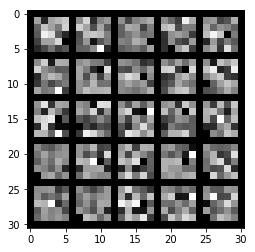

In [517]:
plt.figure(num = 1, figsize = (4, 4))

plt.imshow(display_array, cmap = "gray")